In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-reviews/Reviews.csv


**Importing Libraries & Dataset**

In [2]:
import pandas as pd
import re

data = pd.read_csv('../input/amazon-reviews/Reviews.csv')

def preprocess(text):
    text_input = re.sub('[^a-zA-Z1-9]+', ' ', str(text))
    output = re.sub(r'\d+', '',text_input)
    return output.lower().strip()

data['Text'] = data.Text.map(preprocess)
corpus_cleaned = data['Text'].astype(str).values.tolist()

### For smiplicity, we keep only reviews with 12 words

In [3]:
sentences = []
sentence_length = []

for item in corpus_cleaned:
    word_list = item.split()
    sentences.append(item)
    number_of_words = len(word_list)
    sentence_length.append(number_of_words)

sentences = pd.DataFrame(sentences)
sentence_length = pd.DataFrame(sentence_length)

sentences = sentences.merge(sentence_length, left_index=True, right_index=True)

sentences['number_of_words']=sentences['0_y']
sentences['sentence']=sentences['0_x']
sentences=sentences[['sentence','number_of_words']]
sentences['number_of_words']=sentences['number_of_words'].astype(int)

sentences = sentences[sentences['number_of_words'] == 12]
corpus_cleaned=sentences['sentence'].values.tolist()
corpus = corpus_cleaned

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

# create input sequences using list of tokens
input_sequences = []

for review in corpus:
    token_list = tokenizer.texts_to_sequences([review])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [5]:
import tensorflow.keras.utils as ku
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
total_words = len(tokenizer.word_index) + 1
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

In [6]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import tensorflow as tf

In [7]:
model = Sequential()
model.add(Embedding(total_words, 240, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-07-10 16:33:26.301763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 16:33:26.408645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 16:33:26.409390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 16:33:26.410493: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.93):
            print("\nReached 93% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

history = model.fit(predictors, label, epochs=300, verbose=1, callbacks=[callbacks])

2022-07-10 16:33:29.829511: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300


2022-07-10 16:33:33.919250: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


47/47 [==============================] - 6s 8ms/step - loss: 6.8857 - accuracy: 0.0237
Epoch 2/300
47/47 [==============================] - 0s 7ms/step - loss: 6.0140 - accuracy: 0.0278
Epoch 3/300
47/47 [==============================] - 0s 7ms/step - loss: 5.7361 - accuracy: 0.0292
Epoch 4/300
47/47 [==============================] - 0s 7ms/step - loss: 5.5502 - accuracy: 0.0285
Epoch 5/300
47/47 [==============================] - 0s 7ms/step - loss: 5.3988 - accuracy: 0.0326
Epoch 6/300
47/47 [==============================] - 0s 9ms/step - loss: 5.2733 - accuracy: 0.0387
Epoch 7/300
47/47 [==============================] - 0s 10ms/step - loss: 5.1598 - accuracy: 0.0292
Epoch 8/300
47/47 [==============================] - 0s 10ms/step - loss: 5.0415 - accuracy: 0.0407
Epoch 9/300
47/47 [==============================] - 1s 11ms/step - loss: 4.9382 - accuracy: 0.0461
Epoch 10/300
47/47 [==============================] - 0s 8ms/step - loss: 4.8355 - accuracy: 0.0570
Epoch 11/300
47/47

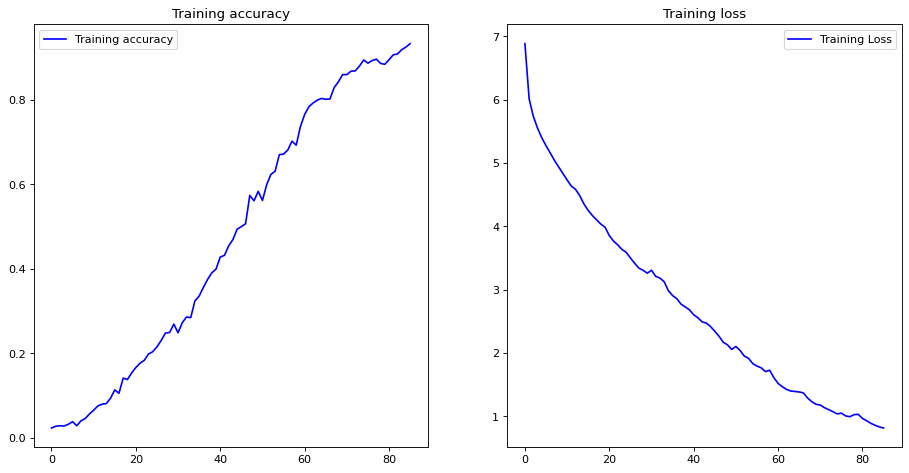

In [9]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

figure(figsize=(14, 7), dpi=80)

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()